In [1]:
import random

from librosa.display import specshow
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset
from torchaudio.transforms import AmplitudeToDB, MelSpectrogram, Resample
import gradio as gr

%load_ext gradio

In [2]:
dataset = load_dataset("danavery/urbansound8k")
filename_to_index = {}
for index, filename in enumerate(dataset["train"]["slice_file_name"]):
    filename_to_index[filename] = index

/home/davery/miniforge3/envs/audio_interp/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [3]:
def fetch_random():
    example_index = random.randint(0, len(dataset['train']) - 1)
    example = dataset['train'][example_index]
    return example

In [4]:
def fetch_example(file_name):
    if file_name == "":
        example = fetch_random()
    else:
        example = dataset["train"][filename_to_index[file_name]]
    waveform = torch.tensor(example["audio"]["array"]).float()
    waveform = torch.unsqueeze(waveform, 0)

    sr = example["audio"]["sampling_rate"]
    return waveform, sr

In [5]:
def make_mel_spectrogram(audio: torch.Tensor, sample_rate, hop_length=256, n_fft=512, n_mels=64) -> torch.Tensor:
    spec_transformer = MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
    )
    mel_spec = spec_transformer(audio).squeeze(0)

    amplitude_to_db_transformer = AmplitudeToDB()
    mel_spec_db = amplitude_to_db_transformer(mel_spec)
    print(mel_spec_db.shape)
    return mel_spec_db

In [6]:
def preprocess(audio, file_sr):
    if audio.shape[0] > 1:
        audio = torch.mean(audio, dim=0, keepdim=True)
    sample_rate = 22050
    resampler = Resample(file_sr, sample_rate)
    audio = resampler(audio)

    num_samples = audio.shape[-1]
    total_duration = num_samples / sample_rate

    return audio, num_samples, total_duration

In [7]:
def normalize_spectrogram(spec):
    spectrogram = (spec - torch.min(spec)) / (torch.max(spec) - torch.min(spec))
    return spectrogram

In [8]:
def generate_spectrogram(audio):
    spectrogram = make_mel_spectrogram(audio, 22050)
    return spectrogram

In [9]:
def generate_spec_figure(file_name=""):
    waveform, sr = fetch_example(file_name)
    audio, _, _ = preprocess(waveform, sr)
    spec = generate_spectrogram(audio)
    norm_spec = normalize_spectrogram(spec)
    fig, ax = plt.subplots(figsize=(5,2))
    img = specshow(norm_spec.numpy(), sr=22050, hop_length=256, x_axis="time", y_axis="mel", ax=ax)
    return fig, gr.Audio(value=(22050, audio[0].numpy()))

torch.Size([64, 345])


/home/davery/miniforge3/envs/audio_interp/lib/python3.10/site-packages/gradio/processing_utils.py:354: UserWarning: Trying to convert audio automatically from float32 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


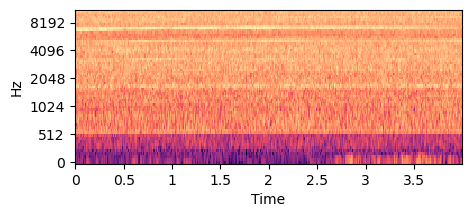

In [10]:
spec = generate_spec_figure("137815-4-0-8.wav")

In [12]:
%%blocks

with gr.Blocks() as demo:

    file_name = gr.Textbox()
    with gr.Row():
        spec = gr.Plot(container=True)
        my_audio = gr.Audio()
    gen_button = gr.Button("Get Spec")
    gen_button.click(fn=generate_spec_figure, inputs=file_name, outputs=[spec, my_audio])
    gr.Examples(examples=[["100263-2-0-117.wav"], ["100852-0-0-0.wav"]], inputs=[file_name], outputs=[spec,my_audio], run_on_click=True, fn=generate_spec_figure)



torch.Size([64, 345])


/home/davery/miniforge3/envs/audio_interp/lib/python3.10/site-packages/gradio/processing_utils.py:354: UserWarning: Trying to convert audio automatically from float32 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))
